In [2]:
import pandas as pd
import konlpy
import gensim

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import keras
import tensorflow as tf

### 1. 데이터 준비와 확인

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("train : ", train_data.shape)
print("test  : ", test_data.shape)

train :  (150000, 3)
test  :  (50000, 3)


### 2. 데이터로더 구성

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    '''중복 제거, 결측값 제거, 토큰화, 불용어 제거, 사전 생성, 인덱싱하는 함수
    Args:
        train_data(pd.DataFrame): train data set
        test_data(pd.DataFrame): test data set
        num_words(int): 단어 수, default=10000
    '''
    ## 중복 제거
    train_data = train_data.drop_duplicates(subset=["document"])
    test_data = test_data.drop_duplicates(subset=["document"])
    
    ## 결측값 제거
    train_data = train_data.dropna(how="any")
    test_data = test_data.dropna(how="any")
    
    ## 토큰화 & 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    ## 사전 word_to_index 구성 <- train 데이터로만 진행!
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] ## <PAD>, <BOS>, <UNK>, <UNUSED>를 위한 인덱스 
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    ## 텍스트 스트링을 사전 인덱스 스트링으로 변환
    ## 오류 코드 ##
#     def wordlist_to_indexlist(wordlist):
#         return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
#     X_train = list(map(wordlist_to_indexlist, X_train))
#     X_test = list(map(wordlist_to_indexlist, X_test))

    ## 오류 수정 ##
    def train_wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNUSED>'] for word in wordlist]
    
    def test_wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(train_wordlist_to_indexlist, X_train))
    X_test = list(map(test_wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
print("X train : ", len(X_train))
print("X test  : ", len(X_test))

X train :  146182
X test  :  49157


### 사전 word_to_index 추가 전처리

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
len(word_to_index)

10000

In [75]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '적': 26,
 '안': 27,
 '정말': 28,
 '로': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '재밌': 34,
 '어': 35,
 '같': 36,
 '점': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '내': 55,
 '최고': 56,
 '~': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '할': 62,
 '왜': 63,
 '겠': 64,
 '1': 65,
 '스토리': 66,
 '해': 67,
 '습니다': 68,
 'ㅋㅋㅋ': 69,
 '...': 70,
 '드라마': 71,
 '생각': 72,
 '아니': 73,
 '더': 74,
 '그': 75,
 '싶': 76,
 '사람': 77,
 '듯': 78,
 '때': 79,
 '감동': 80,
 '함': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '알': 86,
 '만들': 87,
 '내용': 88,
 '볼': 89,
 '감독': 90,
 '보다': 91,
 '라': 92,
 '그냥': 93,
 '재미': 94,
 '시

In [9]:
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
get_decoded_sentences(X_train, index_to_word)

['더 빙 . . 진짜 짜증 나 네요 목소리',
 '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나',
 '재 <UNUSED>',
 '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정',
 '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNUSED> <UNUSED> 너무나 이뻐 보였 다',
 '<UNUSED> <UNUSED> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .',
 '긴장감 을 제대로 살려 내 지 못했 다 .',
 '반개 아깝 다 욕 나온다 <UNUSED> <UNUSED> 연기 생활 몇 년 인지 . . 정말 발 로 해도 그것 보단 낫 겟 다 납치 . 감금 만 반복 반복 . . 드라마 가족 없 다 연기 못 하 사람 만 <UNUSED> 네',
 '없 는데 재미 있 몇 안 되 영화',
 '케 평점 낮 건데 ? 꽤 볼 <UNUSED> . . 헐리우드 식 화려 함 만 너무 <UNUSED> 있 나 ?',
 '. 진짜 짱 다 ♥',
 '때 마다 눈물나 서 죽 겠 다 90 년 대 향수 자극 ! ! <UNUSED> 감성 절제 멜로 달인 다 ~',
 '면서 <UNUSED> 고 <UNUSED> 보도 <UNUSED> 때 <UNUSED> 뻔 이범수 연기 드럽 게 못해',
 '하 고 깔끔 해서 좋 다 . 신문 기사 로 만 보다 보 면 자꾸 <UNUSED> . 그 사람 었 다는 것 을 .',
 '존중 <UNUSED> 진짜 내생 극장 에서 본 영화 중 가장 노 잼 노 감동 임 스토리 어 거지 고 감동 어거지',
 '냥 매번 긴장 되 고 재 밋 음 ㅠㅠ',
 '사람 웃긴 게 바스코 <UNUSED> <UNUSED> 코 라고 까 고 바비 이기 면 아이돌 라고 <UNUSED> . 그냥 까 고 싶 어서 안달 난 것 처럼 보인다',
 '<UNUSED> 표절 인 것 이해 하 는데 왜 뒤 로 갈수록 재미없 어 지 냐',
 '정말 깨알 캐스팅 <UNUSED> 하 지 않 산

In [12]:
get_decoded_sentences(X_test, index_to_word)

['ㅋ',
 '',
 '야 평점 . ... 나쁘 진 않 지만 10 점 짜리 더더욱 아니 잖아',
 '하 지 않 은데 완전 막장 임 . .. 돈 주 고 보 기 . ...',
 'D 만 아니 었 어도 별 다섯 개 줬 을 텐데 . . 왜 3 D 로 나와서 제 <UNK> 불편 하 게 하 죠 ? ?',
 '주 된 , 최고 음악 영화',
 '쓰레기',
 '미국 애니 에서 <UNK> 듯 창의 력 없 로봇 디자인 부터 , 고개 젖 게 한다',
 '개판 되 중국 영화 유치 하 고 내용 없 음 폼 잡 다 끝 남 말 안 되 무기 유치 cg <UNK> 아 그립 다 <UNK> 같 영화 이건 3 류 아류 작 다',
 '아픔 뒤 <UNK> 새로운 인연 기쁨 But , 모든 사람 그렇 지 않 네 . .',
 '네요 오랜만 포켓몬스터 잼 <UNK>',
 '독립영화 한계 그렇게 아버지 된다 비교 됨',
 '아름답 다 그 아름다움 이성 을 흔들 어 놓 는다 . <UNK> 아름다움 을 <UNK> 섬세 하 고 아름다운 <UNK> 같 퀴어 영화 다 .',
 '보이 반전 었 지만 영화 <UNK> 사라지 지 않 았 다 .',
 '스토리 , 연출 , 연기 , 비주얼 등 영화 기본 조차 안 된 영화 무슨 평 을 해 . 이런 영화 찍 고 <UNK> 감독 "" 내 영화 경력 몇 OO 인데 <UNK> 내 영화 평론 해 ? "" 같 마인드 빠져 있 겠 지 ? "',
 'ㅈ <UNK> 라는 평점 뭐 냐 ?',
 '! <UNK>',
 '도저히 못 보 겠 다 진짜 이렇게 연기 못 할 거 라곤 상상 못했 네',
 '',
 '재미 없 거 우려먹 어 . ... 챔프 에서 방송 몇 번 했 더라 ? ㅋㅋㅋ ㅋㅋㅋ ㅋㅋㅋ ㅋㅋ',
 "13 일 금요일 <UNK> ' <UNK> ' 시리즈 함께 가장 많 시리즈 양산 해냈 던 헬 <UNK> 시리즈 첫 편 . 작가 상상력 돋보이 작품 며 , <UNK> 로 사 지 찢 고어 씬 지금 보 더라도 상당히 잔인 하 고 충격 적 다 .",
 '교훈 돋 기 하 지만 어쩔 수 없이 저 평점 받 을 수

### 오류 수정 과정
train set에서 decoding을 해보니 '재 `<UNK>`'와 같이 `<UNK>`가 사용되었다. 
따라서 사전을 구성할 때 수정해서 '재 `<UNUSED>`'로 나오도록 해야겠다. 

train set에는 `<UNUSED>`가 test set에는 `<UNK>`가 나오도록 수정하였다.

### 3. 모델 구성을 위한 데이터 분석 및 가공

In [13]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.round(np.sum(num_tokens < max_tokens) / len(num_tokens), 2)*100}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.0%가 maxlen 설정값 이내에 포함됩니다. 


In [14]:
X_train = keras.preprocessing.sequence.pad_sequences(
    X_train,
    value=word_to_index["<PAD>"],
    padding='pre', # post에 비해 높은 성능을 내는 pre를 사용
    maxlen=maxlen
)

X_test = keras.preprocessing.sequence.pad_sequences(
    X_test,
    value=word_to_index["<PAD>"],
    padding='pre', # post에 비해 높은 성능을 내는 pre를 사용
    maxlen=maxlen
)

In [15]:
print('1번째 문장 길이: ', len(X_train[0]))
print('2번째 문장 길이: ', len(X_train[1]))

1번째 문장 길이:  41
2번째 문장 길이:  41


### 4. 모델 구성 및 validation set 구성
1. lstm(32) -> dense(8)
2. lstm(32) with bidirectional -> dense(8)
3. gru(32) -> dense(8)

In [26]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [51]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

1. word_vector_dim 16 -> 30으로 수정

In [52]:
# model1 : lstm(32) -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.LSTM(32)(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model1 = keras.Model(inputs, outputs)

# model2 : lstm(32) with bi -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(32))(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)

# model3 : gru(32) -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))(inputs)
x = keras.layers.GRU(32)(x)
x = keras.layers.Dense(8, activation="relu")(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model3 = keras.Model(inputs, outputs)

In [53]:
model1.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 41, 30)            300000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8064      
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 308,337
Trainable params: 308,337
Non-trainable params: 0
_________________________________________________________________


In [54]:
model2.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 41, 30)            300000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16128     
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 316,657
Trainable params: 316,657
Non-trainable params: 0
_________________________________________________________________


In [55]:
model3.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 41)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 41, 30)            300000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6144      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 306,417
Trainable params: 306,417
Non-trainable params: 0
_________________________________________________________________


### 5. 모델 훈련 개시 & 6. Loss, Accuracy 그래프 시각화

In [56]:
epochs=20

In [57]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 8ms/step - loss: 0.4561 - accuracy: 0.7859 - val_loss: 0.3480 - val_accuracy: 0.8500
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3271 - accuracy: 0.8606 - val_loss: 0.3316 - val_accuracy: 0.8558
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3014 - accuracy: 0.8727 - val_loss: 0.3318 - val_accuracy: 0.8575
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2820 - accuracy: 0.8821 - val_loss: 0.3318 - val_accuracy: 0.8591
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2640 - accuracy: 0.8914 - val_loss: 0.3313 - val_accuracy: 0.8600
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2479 - accuracy: 0.8982 - val_loss: 0.3356 - val_accuracy: 0.8567
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2301 - accuracy: 0.9064 - val_loss: 0.3564 - val_accuracy: 0.8565
Epoch 

In [58]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 3s - loss: 0.6824 - accuracy: 0.8366
[0.6824029684066772, 0.8366051912307739]


In [59]:
import matplotlib.pyplot as plt

def result_visualization(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

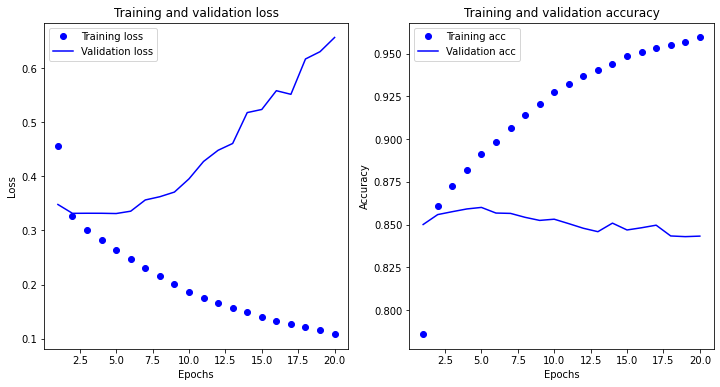

In [60]:
result_visualization(history1)

In [61]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 10ms/step - loss: 0.4439 - accuracy: 0.7939 - val_loss: 0.3431 - val_accuracy: 0.8502
Epoch 2/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3306 - accuracy: 0.8585 - val_loss: 0.3381 - val_accuracy: 0.8535
Epoch 3/20
266/266 [==============================] - 2s 7ms/step - loss: 0.3100 - accuracy: 0.8684 - val_loss: 0.3316 - val_accuracy: 0.8564
Epoch 4/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2924 - accuracy: 0.8773 - val_loss: 0.3281 - val_accuracy: 0.8578
Epoch 5/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2752 - accuracy: 0.8846 - val_loss: 0.3284 - val_accuracy: 0.8589
Epoch 6/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2591 - accuracy: 0.8932 - val_loss: 0.3342 - val_accuracy: 0.8597
Epoch 7/20
266/266 [==============================] - 2s 7ms/step - loss: 0.2419 - accuracy: 0.9013 - val_loss: 0.3455 - val_accuracy: 0.8558
Epoch

In [62]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 4s - loss: 0.6395 - accuracy: 0.8355
[0.6395325064659119, 0.8355473279953003]


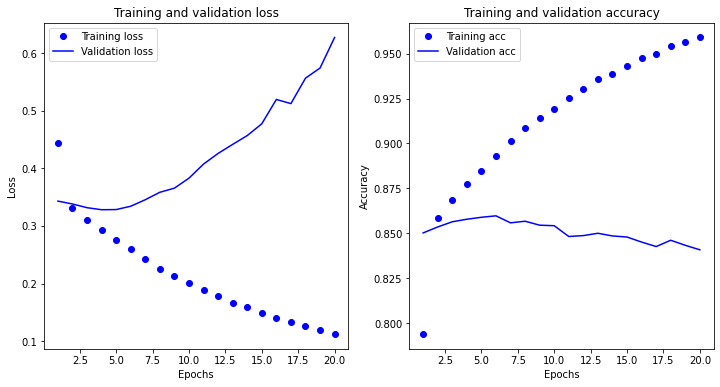

In [63]:
result_visualization(history2)

In [64]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 7ms/step - loss: 0.4656 - accuracy: 0.7759 - val_loss: 0.3502 - val_accuracy: 0.8475
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3361 - accuracy: 0.8582 - val_loss: 0.3414 - val_accuracy: 0.8510
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3173 - accuracy: 0.8680 - val_loss: 0.3387 - val_accuracy: 0.8525
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.3045 - accuracy: 0.8740 - val_loss: 0.3360 - val_accuracy: 0.8524
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2924 - accuracy: 0.8802 - val_loss: 0.3394 - val_accuracy: 0.8553
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2797 - accuracy: 0.8864 - val_loss: 0.3347 - val_accuracy: 0.8547
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.2661 - accuracy: 0.8932 - val_loss: 0.3404 - val_accuracy: 0.8522
Epoch 

In [65]:
results3 = model3.evaluate(X_test,  y_test, verbose=2)

print(results3)

1537/1537 - 3s - loss: 0.5634 - accuracy: 0.8388
[0.5633634328842163, 0.8387818336486816]


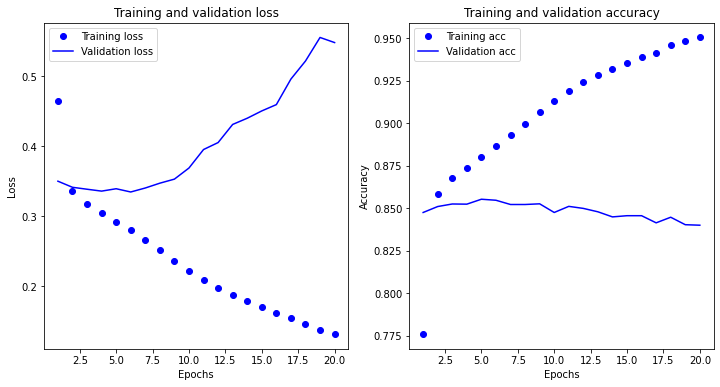

In [66]:
result_visualization(history3)

### 7. 학습된 Embedding 레이어 분석

In [67]:
embedding_layer = model3.layers[1]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 30)


### 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [105]:
import os
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [77]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

In [136]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [160]:
# model4 : embedding -> gru(32) -> dense(8)
inputs = keras.Input(shape=(41, ))
x = keras.layers.Embedding(
    vocab_size, 
    word_vector_dim, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    input_length=maxlen, 
    trainable=True
)(inputs)
x = keras.layers.GRU(64)(x)
x = keras.layers.Dense(32, activation="relu")(x)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dropout(0.05)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model4 = keras.Model(inputs, outputs)

In [161]:
model4.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 41)]              0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
gru_11 (GRU)                 (None, 64)                31872     
_________________________________________________________________
dense_39 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_40 (Dense)             (None, 8)                 264       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 9  

In [162]:
# 학습의 진행
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 3s 8ms/step - loss: 0.5045 - accuracy: 0.7443 - val_loss: 0.3858 - val_accuracy: 0.8268
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3631 - accuracy: 0.8411 - val_loss: 0.3433 - val_accuracy: 0.8485
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3199 - accuracy: 0.8630 - val_loss: 0.3278 - val_accuracy: 0.8550
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2923 - accuracy: 0.8780 - val_loss: 0.3254 - val_accuracy: 0.8603
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2733 - accuracy: 0.8869 - val_loss: 0.3233 - val_accuracy: 0.8578
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2554 - accuracy: 0.8955 - val_loss: 0.3257 - val_accuracy: 0.8614
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2408 - accuracy: 0.9020 - val_loss: 0.3336 - val_accuracy: 0.8580
Epoch 

In [163]:
# 테스트셋을 통한 모델 평가
results4 = model4.evaluate(X_test,  y_test, verbose=2)

print(results4)

1537/1537 - 3s - loss: 0.6972 - accuracy: 0.8440
[0.6971885561943054, 0.8439896702766418]


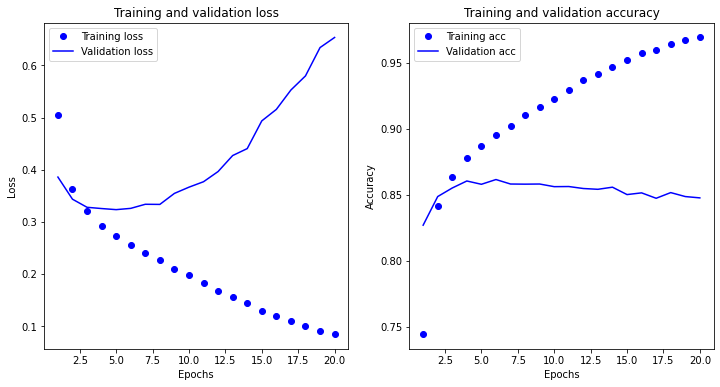

In [164]:
result_visualization(history4)

### 회고
자연어 처리의 여러 모델을 사용해볼 수 있어 좋았다. 
여러가지 전처리를 추가하는 실험을 진행하면 성능이 더 오를까??